# Hyperparams

In [1]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import time
start_time = time.time()
import torch
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wandb.init(project="BA-MAE", entity="alexandermittet")

########### PATHS ############
pretrain_path =     r'C:\Users\alx\Downloads\BA_data\frames'
#for t-sne:
pretrain_path_imgs = '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames/class_0'
val_path =          r'C:\Users\alx\Downloads\BA_data\val_frames'
#for t-sne:
val_path_imgs =     "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/validation_frames/class_0"
fine_tune_path =    'C:\\Users\\alx\\Downloads\\img\\img'

########### HYPER PARAMETERS ############
### MODEL SIZE
emb_dims =          192*4#192 #skal ku duvuderes med num_heads som er 4 
                    #85M params i TIMM classifiers, så den har vi smags til at 190*4 passer med 12 layers
encoder_layers =    12#12 i timm


### Pretraining
load_prev_model =   False
load_prev_model_path = r"C:\Users\alx\Downloads\mdl_ckpt\mae_m-0.75\mae_best_e-328_7.5M.pth"
training =          False
num_epochs =        0
dim =               224
batch_size =        32
mask_ratio =        0.75
# wandb.config.mask_ratio = mask_ratio
# wandb.config.batch_size = batch_size

### Fine-tuning
fine_tuning =       True
load_fine_tuned =   False
fine_tune_eval =    True
num_fine_epochs =   60 #overfitter efter færre faktisk, men vi gemmer også best

eval_plot_name =    f"Baseline_e-{num_fine_epochs}_PreTrain_MAE_e-{num_epochs}_mask-{mask_ratio}_embdims-{emb_dims}"
load_prev_fine_model_path = f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\baseline_mes_best_embdims-{emb_dims}.pth'

### T-sne feature plotting
tsne_plotting =     False
tsne_target =       "validation images"
plot_single_image = True
plot_16_images =    True

### Misc
get_num_params =    True
break_after_num_steps = -1
use_class4 =        False

run_name =          f"e-{num_epochs}_m-{mask_ratio}_fine-e-{num_fine_epochs}_bs-{batch_size}_emb_dim-{emb_dims}"

## Dataset

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
#import torch.optim as optim #bruger prodigy
from torch.utils.data import DataLoader
import numpy as np
from prodigyopt import Prodigy
import lightning as L
# import wandb

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block
from tqdm import tqdm

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((dim, dim)), # Resize the image to #32x32
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
])

#dataset = CustomFramesDataset(root_dir=frames_path, transform=transform)
dataset = ImageFolder(
        pretrain_path,
        transform=transform,
    )

val_dataset = ImageFolder(
        val_path,
        transform=transform,
    ) 

c:\Users\alx\miniconda3.2\envs\BA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# model architecture + masking fn

In [4]:
## ViT Model + functions
class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=emb_dims,
                 num_layer=encoder_layers,
                 num_head=4,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        
        # Calculate the number of patches
        num_patches = patches.shape[0]
        

        
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=emb_dims,#192,
                 encoder_layer=encoder_layers,#12,
                 encoder_head=4,
                 decoder_layer=4,
                 decoder_head=4,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=4) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits
    

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes
    
def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

def mask_image(image, mask_size):
    mask = torch.ones_like(image)
    mask[:, :mask_size, :mask_size] = 0
    return image * mask

## load  pre-train model if it exists

In [5]:
def load_model():
    import torch
    import os

    if os.path.exists(load_prev_model_path):
        # Load the checkpoint
        checkpoint = torch.load(load_prev_model_path)
        
        # Load the model state dict
        model = MAE_ViT().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state dict
        optimizer = Prodigy(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Load the loss
        loss = checkpoint['loss']
        
        print(f"Model loaded with loss: {loss}")
    else:
        model = MAE_ViT().to(device)
        print("Model checkpoint not found. Init model from scratch.")
    return model, optimizer, loss

if load_prev_model:
    model, optimizer, loss = load_model()
else:
    model = MAE_ViT().to(device)
    optimizer = Prodigy(model.parameters())
    #loss er custom mse loss

# Num_params in MAE model

In [6]:
if get_num_params:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,.0f}")

Total number of parameters: 114,855,168


# Pre-Train model:

In [7]:
if training:    #Tensorboard writer
    from torchsampler import ImbalancedDatasetSampler
    
    from datetime import datetime
    now = datetime.now()
    # Format the datetime string to exclude the year
    formatted_datetime = now.strftime("%m-%d_%H-%M")
    # Use the formatted datetime in the path
    writer = SummaryWriter(os.path.join("logs", "mae", f"{formatted_datetime}_{run_name}"))

    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(dataset)) #sampler=cycle_sampler
    val_loader =dataloader = DataLoader(val_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(val_dataset))
    criterion = torch.nn.MSELoss() #pas
    
    best_val_loss = float('inf')
    step_count = 0
    for epoch in range(num_epochs):
        model.train()
        losses = []
        pbar = tqdm(iter(dataloader))
        for img, label in pbar:
            step_count += 1
            img = img.to(device)
            predicted_img, mask = model(img)
            loss = (
                    torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
                )
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

            pbar.set_postfix({'step loss': loss.item()}, refresh=False)
            writer.add_scalar("mae_step_loss", loss.item(), global_step=step_count)
            # wandb.log({"Train Loss step": loss})

            if break_after_num_steps > 0: #set to -1 to disable early breaking
                if step_count >= break_after_num_steps: #Save and quit
                    # torch.save({
                    #             'model_state_dict': model.state_dict(),
                    #             'optimizer_state_dict': optimizer.state_dict(),
                    #             'loss': loss.item(),
                    #             }, './models/mae_checkpoint_break.pth')
                    break
        
        #For every epoch:
        avg_loss = sum(losses) / len(losses)
        writer.add_scalar("mae_epoch_loss", avg_loss, global_step=step_count)
        print(f"In epoch {epoch}, average training loss is {avg_loss}.")
        # wandb.log({"Train Loss epoch avg": avg_loss})

        """ visualize the first 16 predicted images on val dataset"""
        model.eval()
        with torch.no_grad():
            val_img, label = iter(val_loader)
            #val_img = torch.stack([val_dataset[i][0] for i in range(16)]) #using val_loader instead
            val_img = val_img.to(device)
            predicted_val_img, mask = model(val_img)
            #raw data acc:
            val_loss = (
                    torch.mean((predicted_val_img - val_img) ** 2 * mask) / mask_ratio
                )
            writer.add_scalar("mae_epoch_val_loss", val_loss.item(), global_step=step_count)

            #converting for 16x plotting
            predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
            img = torch.cat(
                [val_img * (1 - mask), predicted_val_img, val_img], dim=0
            )
            img = rearrange(
                img, "(v h1 w1) c h w -> c (h1 h) (w1 v w)", w1=2, v=3
            )
            writer.add_image("mae_image", (img + 1) / 2, global_step=epoch)
            # transform = transforms.ToPILImage()
            # pil_img = transform(img)
            # wandb_img = wandb.Image(pil_img)
            # wandb.log({"16 val mae_images": wandb_img})

        """ save model """
        # base_path = "C:\\Users\\alx\\Downloads\\mdl_ckptmae_checkpoint_epoch"
        # torch.save({
        #             'model_state_dict': model.state_dict(),
        #             'optimizer_state_dict': optimizer.state_dict(),
        #             'loss': loss.item(),
        #             }, os.path.join(base_path, f"-{epoch}_{step_count}_mask-{mask_ratio}.pth"))
        if val_loss < best_val_loss:
            # Update the best loss
            best_val_loss = val_loss
            
            # Construct the filename with the current loss included
            filename = f"mae_best.pth"
        else:
            filename = "mae_last.pth"
        # Construct the full path using os.path.join
        base_path = f"C:\\Users\\alx\\Downloads\\mdl_ckpt\\mae_m-{mask_ratio}"
        full_path = os.path.join(base_path, filename)
        
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, full_path)
            
        print(f"Model saved with avg loss {avg_loss:.4f} at {full_path}")


# Eval 16 imgs

c:\Users\alx\miniconda3.2\envs\BA\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


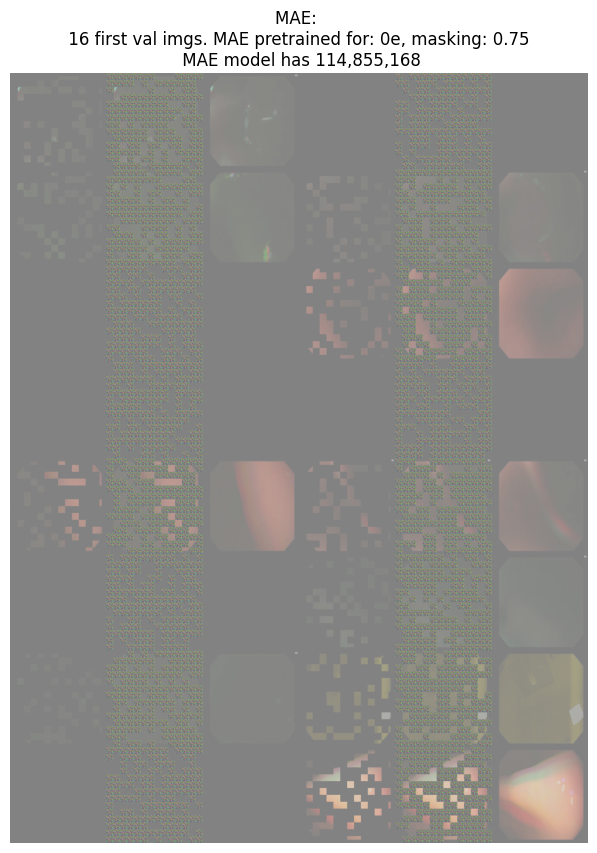

In [8]:
if plot_16_images:
    import matplotlib.pyplot as plt
    val_img = torch.stack([val_dataset[i][0] for i in range(16)])
    val_img = val_img.to(device)
    predicted_val_img, mask = model(val_img)
    predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
    img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
    img = rearrange(img, "(v h1 w1) c h w -> (h1 h) (w1 v w) c", w1=2, v=3)
    img_np = img.cpu().detach().numpy()
    min_val, max_val = np.min(img_np), np.max(img_np)
    range_val = max_val - min_val

    # Normalize the data
    normalized_img_np = (img_np - min_val) / range_val

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(f'MAE: \n 16 first val imgs. MAE pretrained for: {num_epochs}e, masking: {mask_ratio} \n MAE model has {total_params:,.0f}')
    plt.imshow(normalized_img_np)
    plt.savefig(f"plots/mae_image_16x_e-{num_epochs}_m-{mask_ratio}_params-{total_params:,.0f}.png")
    plt.show()

# T-SNE current results

#### DO the work one time:

In [9]:
def tsne_embeddings(input_path):
    from torchvision import transforms
    from PIL import Image
    import numpy as np

    import torch

    #model, optimizer, loss = load_model() # we do this in another cell
    # Extract the encoder
    encoder = model.encoder
    encoder.eval() # Set the model to evaluation mode

    import os

    # Specify the directory containing your images
    image_dir = input_path
    all_files = os.listdir(image_dir)
    # Filter out image files (assuming .jpg and .png extensions)
    image_files = [file for file in all_files if file.endswith(('.jpg', '.png'))]

    # Construct the full paths to the image files
    image_paths = [os.path.join(image_dir, file) for file in image_files]
    # Load and preprocess images
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Adjust size as needed
        transforms.ToTensor(),
    ])


    from tqdm import tqdm # Import tqdm

    # Extract features
    features = []
    for path in tqdm(image_paths, desc="Processing images"): # Wrap image_paths with tqdm
        img = Image.open(path)
        img = transform(img).unsqueeze(0) # Add batch dimension
        with torch.no_grad():
            _, feature = encoder(img)
        features.append(feature.squeeze().numpy())

    # Stack features into a 2D array
    features_array = np.vstack(features)

    from sklearn.manifold import TSNE

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    embedding = tsne.fit_transform(features_array)

    import matplotlib.pyplot as plt
    return embedding

if tsne_plotting:
    if tsne_target == "training images":
        embedding = tsne_embeddings(pretrain_path_imgs)
    elif tsne_target == "validation images":
        embedding = tsne_embeddings(val_path_imgs)
    else:
        print("Invalid target for t-SNE plotting. Please choose either 'training images' or 'validation images'.")

### Just tsne plot:

In [10]:
if False:# Plot the 2D embedding
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title('t-SNE visualization of image embeddings')
    plt.show()

### tsne with images on top

In [11]:
def plot_tsne(input_path, which_type):
    import os
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    def getImage(path, zoom=.025):
        return OffsetImage(plt.imread(path), zoom=zoom)

    # Specify the directory containing the images
    image_directory = input_path

    # List all files in the directory
    files = os.listdir(image_directory)

    # Filter out the image files (assuming .jpg and .png extensions)
    image_files = [os.path.join(image_directory, f) for f in files if f.endswith(('.jpg', '.png'))]

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Assuming 'embedding' is defined elsewhere in your code
    for x0, y0, path in zip(embedding[:, 0], embedding[:, 1], image_files):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

    # Set the limits of the plot to ensure all images are visible
    # You might need to adjust these limits based on the range of your embedding coordinates
    ax.set_xlim(embedding[:, 0].min(), embedding[:, 0].max())
    ax.set_ylim(embedding[:, 1].min(), embedding[:, 1].max())
    from datetime import datetime
    now = datetime.now()
    timestamp = now.strftime("%y%m%d_%H%M")
    
    title = f" T-sne plot of feature embeddings of {which_type} images. Mask Ratio: {mask_ratio}"

    # Set the title of the plot
    ax.set_title(title)

    # Save the figure with the datetime stamp in the filename
    plt.savefig(f'./plots/tsne_time-{timestamp}_mask-{mask_ratio}_type-{which_type}.png')
    plt.show()

if tsne_plotting:
    if tsne_target == "training images":
        plot_tsne(pretrain_path_imgs, 'training')
    elif tsne_target == "validation images":
        plot_tsne(val_path_imgs,'validation')

# Fine tune model MES score

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchsampler import ImbalancedDatasetSampler
encoder = model.encoder
classifier = ViT_Classifier(encoder, num_classes=4)
classifier.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = Prodigy(classifier.parameters())

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = f'{fine_tune_path}/{img_name}' ##### MAN KAN ÆNDRE PATH HER ift /class_0
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.df.iloc[idx, 2], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label
    def get_labels(self):
        label = torch.tensor(self.df.iloc[:, 2].tolist(), dtype=torch.long)
        return label
    
def init_dataloaders():
        #DATA LABELS
    df = pd.read_csv('img_labels_ALL.csv')

    # Remove class 4 (images lablelled as bad examples)?
    if use_class4 == False:
        df = df[df['score'] != 4.0]
    #df.head() #Sanity check

    # Only use images that exist in the directory
    image_folder = fine_tune_path
    image_exists = df['img'].apply(lambda x: os.path.isfile(os.path.join(image_folder, x))) 
    filtered_df = df[image_exists]
    print(f"Original DataFrame size: {len(df)}, Filtered DataFrame size: {len(filtered_df)}") #Sanity check
    df = filtered_df

    # Stratify/balance classes across splits
    labels = df['score'].values
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=labels)
    train_labels = train_df['score'].values
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_labels)

    # Create data loaders for training and validation sets
    test_data = CustomDataset(test_df, transform)
    train_data = CustomDataset(train_df, transform)
    val_data = CustomDataset(val_df, transform)

    #More workers for GPU/lambda
    if torch.cuda.is_available():
        num_workers_local = 0
        test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers_local)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data))#, num_workers=num_workers_local)
        val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers_local)
    else:
        test_loader = DataLoader(test_data, batch_size=batch_size)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data))
        val_loader = DataLoader(val_data, batch_size=batch_size)
    return train_loader, val_loader, test_loader, test_data

train_loader, val_loader, test_loader, test_data = init_dataloaders()
from datetime import datetime

# Get the current date and time
now = datetime.now()

# Format the datetime string to exclude the year
formatted_datetime = now.strftime("%m-%d_%H-%M")

# Use the formatted datetime in the path
writer = SummaryWriter(os.path.join("logs", "MES", f"{formatted_datetime}_{run_name}"))

#writer = SummaryWriter(os.path.join("logs", "MES", "MES_fine_tune"))

if fine_tuning == True:
    best_val_loss = float('inf')
    step_count = 0
    best_epoch_was = 0
    for epoch in range(num_fine_epochs):
        
        losses = []
        pbar = tqdm(iter(train_loader))
        classifier.train() # Set the model to training mode
        running_loss = 0.0
        for images, labels in pbar:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = classifier(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            pbar.set_postfix({'step loss': loss.item(), 'epoch': epoch}, refresh=False)
            writer.add_scalar('Fine_tune_loss/train-step', loss.item(), global_step=step_count)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            step_count += 1
            # Update running loss
            running_loss += loss.item() * images.size(0)
        
        # Compute average loss over the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        writer.add_scalar('Fine_tune_loss/train-epoch', epoch_loss, global_step=step_count)
        
        # Validation loop
        classifier.eval() # Set the model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = classifier(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item() * images.size(0)
        
        # Compute average validation loss over the epoch
        val_epoch_loss = running_val_loss / len(val_loader.dataset)
        writer.add_scalar('Fine_tune_loss/val-epoch', val_epoch_loss, global_step=step_count)

        #save model after each epoch
        torch.save({
                    'model_state_dict': classifier.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_last.pth')
        
        #save as best if best
        if val_epoch_loss < best_val_loss:
            best_epoch_was = epoch
            best_val_loss = val_epoch_loss
            torch.save({
                    'model_state_dict': classifier.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    'best_epoch_was': best_epoch_was,
                    }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_best.pth')


    print(f"Fine-tuning complete. Best epoch was {best_epoch_was}")


Original DataFrame size: 1738, Filtered DataFrame size: 1738


100%|██████████| 35/35 [00:56<00:00,  1.61s/it, step loss=0.115, epoch=59]


Fine-tuning complete. Best epoch was 30


# Load fine tuned:

In [13]:
if load_fine_tuned:
    import torch
    import os

    # Load the checkpoint
    checkpoint = torch.load(load_prev_fine_model_path)
    encoder = MAE_Encoder(image_size=dim, mask_ratio=mask_ratio, emb_dim=emb_dims) #xxx
    # Load the model state dict
    classifier = ViT_Classifier(encoder).to(device)#
    classifier.load_state_dict(checkpoint['model_state_dict'])
    
    # Load the optimizer state dict
    optimizer = Prodigy(classifier.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load the loss
    loss = checkpoint['loss']

    best_epoch_was = checkpoint['best_epoch_was']
    
    print(f"Model loaded with loss: {loss}, where best epoch was {best_epoch_was}")


# Eval fine tuned calc

In [14]:
if fine_tune_eval == True:    
    #from sklearn.metrics import classification_report
    from concurrent.futures import ThreadPoolExecutor
    from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score


    from tqdm import tqdm
    import seaborn as sns
    import matplotlib.pyplot as plt

    def evaluate_single_sample(i):
        # Get the sample from the dataset
        sample, true_label = test_data[i]
        
        # Move the sample to the same device as the model
        sample = sample.to(device)
        
        # Pass the sample through the model
        with torch.no_grad():
            prediction = classifier(sample.unsqueeze(0))  # Unsqueeze to add batch dimension

        class_probabilities = prediction[0]


        _, predicted_class = torch.max(class_probabilities, dim=0)

        # Move the predicted_class back to CPU for further operations
        predicted_class = predicted_class.to('cpu')
        

        
        # Return the true label and the predicted class
        return true_label.item(), predicted_class.item()

    # Ensure the model is in evaluation mode
    classifier.eval()

    # Shared lists to store true labels and predicted classes
    true_labels_list = []
    predicted_classes_list = []

    # Evaluate all samples sequentially
    for i in tqdm(range(len(test_data)), desc='Evaluating'):
        true_label, predicted_class = evaluate_single_sample(i)
        true_labels_list.append(true_label)
        predicted_classes_list.append(predicted_class)

    # Assuming `true_labels` and `predicted_labels` are already defined
    f1 = f1_score(true_labels_list, predicted_classes_list, average='weighted')
    accuracy = accuracy_score(true_labels_list, predicted_classes_list)
    precision = precision_score(true_labels_list, predicted_classes_list, average='weighted')
    recall = recall_score(true_labels_list, predicted_classes_list, average='weighted')
    cm = confusion_matrix(true_labels_list, predicted_classes_list)


Evaluating: 100%|██████████| 348/348 [00:13<00:00, 25.20it/s]


# Num params in clf

In [15]:
total_params = sum(p.numel() for p in classifier.parameters())
print(f"Total number of parameters: {total_params:,.0f}")

Total number of parameters: 85,773,316


# Eval fine tune plot

In [16]:
# if fine_tune_eval == True:    
#     # Create a figure and a 2x2 grid of subplots
#     fig, axs = plt.subplots(2, 2, figsize=(15, 10))

#     # Confusion matrix subplot
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0, 0])
#     axs[0, 0].set_title('Confusion Matrix')
#     axs[0, 0].set_xlabel('Predicted')
#     axs[0, 0].set_ylabel('True')

#     # F1 Score subplot
#     axs[0, 1].text(0.5, 0.5, f'F1 Score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
#     axs[0, 1].axis('off')

#     # Precision subplot
#     axs[1, 0].text(0.5, 0.5, f'Precision: {precision:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
#     axs[1, 0].axis('off')

#     # Recall subplot
#     axs[1, 1].text(0.5, 0.5, f'Recall: {recall:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
#     axs[1, 1].axis('off')

#     plt.tight_layout()
#     plt.title(f'Confusion Matrix of MES-scores - \n pretrained for: {num_epochs}e, fine tuned for: {num_fine_epochs}e, masking: {mask_ratio} \n model has {total_params:,.0f} num params. Model used: best (val loss), converged on e-{best_epoch_was}')

#     plt.savefig(f'./plots/eval_plot-{eval_plot_name}.png')
#     plt.show()

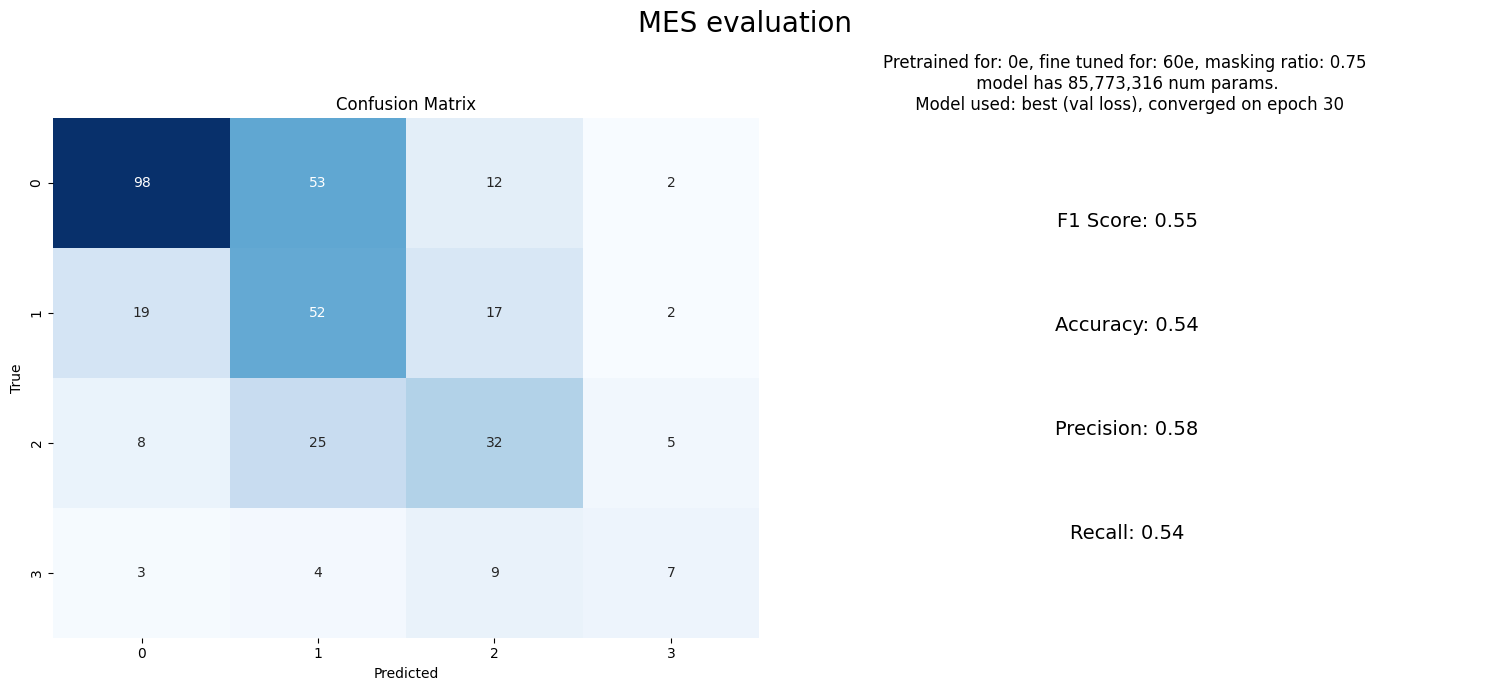

In [17]:
if fine_tune_eval == True:    
    # Create a figure and a 2x1 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # Confusion matrix subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
    axs[0].set_title('Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')

    # F1 Score, Precision, Recall, and Accuracy subplot
    axs[1].set_title(f'Pretrained for: {num_epochs}e, fine tuned for: {num_fine_epochs}e, masking ratio: {mask_ratio} \n model has {total_params:,.0f} num params. \n Model used: best (val loss), converged on epoch {best_epoch_was}')
    axs[1].text(0.5, 0.8, f'F1 Score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
    axs[1].text(0.5, 0.4, f'Precision: {precision:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
    axs[1].text(0.5, 0.2, f'Recall: {recall:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
    axs[1].text(0.5, 0.6, f'Accuracy: {accuracy:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
    axs[1].axis('off')
    
    fig.suptitle(f'MES evaluation', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'./plots/eval_plot-{eval_plot_name}.png')
    plt.show()

In [18]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime of this cell: {total_time//60} mins")

Total runtime of this cell: 67.0 mins


In [19]:
import winsound

# Play a sound
winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
winsound.PlaySound("SystemExit", winsound.SND_ALIAS)